In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

2023-10-22 02:52:44.841028: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 02:52:44.841101: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 02:52:44.841120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 02:52:44.845975: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3*1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-22 02:52:46.129137: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 02:52:46.132289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 02:52:46.132326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 02:52:46.135452: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-22 02:52:46.135507: I tensorflow/compile

In [3]:
train_images_path ="./images/train/"
test_images_path ="./images/validation/"

In [4]:
labels = ["angry","disgust","fear","happy","neutral","sad","surprise"]

In [5]:
def loadImages(folderPath):
    images = []
    directories = set()
    labels = []
    for file in os.listdir(folderPath):
        if os.path.isdir(os.path.join(folderPath,file)):
            directories.add(file)
        else:
            label = os.path.basename(folderPath)
            labels.append(label)
            if file.endswith('jpg') == False:
                continue
            img = plt.imread(os.path.join(folderPath,file))
            if img is not None:
                images.append(img)
                
    for dir in directories:
        retImages,retLabels =  loadImages(os.path.join(folderPath,dir))
        if retImages is not None and len(retImages) > 0:
            images += retImages
            labels += retLabels
    
    print("Loaded ",len(images)," images from ",folderPath)
    return images, labels

In [6]:
train_images,train_labels = loadImages(train_images_path)
test_images,test_labels = loadImages(test_images_path)

Loaded  4938  images from  ./images/train/sad
Loaded  7164  images from  ./images/train/happy
Loaded  4982  images from  ./images/train/neutral
Loaded  3205  images from  ./images/train/surprise
Loaded  3993  images from  ./images/train/angry
Loaded  436  images from  ./images/train/disgust
Loaded  4103  images from  ./images/train/fear
Loaded  28821  images from  ./images/train/
Loaded  1139  images from  ./images/validation/sad
Loaded  1825  images from  ./images/validation/happy
Loaded  1216  images from  ./images/validation/neutral
Loaded  797  images from  ./images/validation/surprise
Loaded  960  images from  ./images/validation/angry
Loaded  111  images from  ./images/validation/disgust
Loaded  1018  images from  ./images/validation/fear
Loaded  7066  images from  ./images/validation/


In [7]:
print("Number of train images loaded: ",len(train_images))
print("Number of train labels loaded: ",len(train_labels))
print("Number of test images loaded: ",len(test_images))
print("Number of test labels loaded: ",len(test_labels))

Number of train images loaded:  28821
Number of train labels loaded:  28821
Number of test images loaded:  7066
Number of test labels loaded:  7066


In [8]:
def getLabelRanges(labelData,labels):
    labelRanges = []
    for label in labels:
        labelRanges.append([i for i, x in enumerate(labelData) if x == label])
    return labelRanges
    

In [9]:
label_ranges_train = getLabelRanges(train_labels,labels)
label_ranges_test = getLabelRanges(test_labels,labels)

per_label_range_train = []
for sets in label_ranges_train:
    per_label_range_train.append((min(sets),max(sets),train_labels[sets[0]],len(sets)))
    
per_label_range_train

[(20289, 24281, 'angry', 3993),
 (24282, 24717, 'disgust', 436),
 (24718, 28820, 'fear', 4103),
 (4938, 12101, 'happy', 7164),
 (12102, 17083, 'neutral', 4982),
 (0, 4937, 'sad', 4938),
 (17084, 20288, 'surprise', 3205)]

# Train Class Distribution Plotting

<BarContainer object of 7 artists>

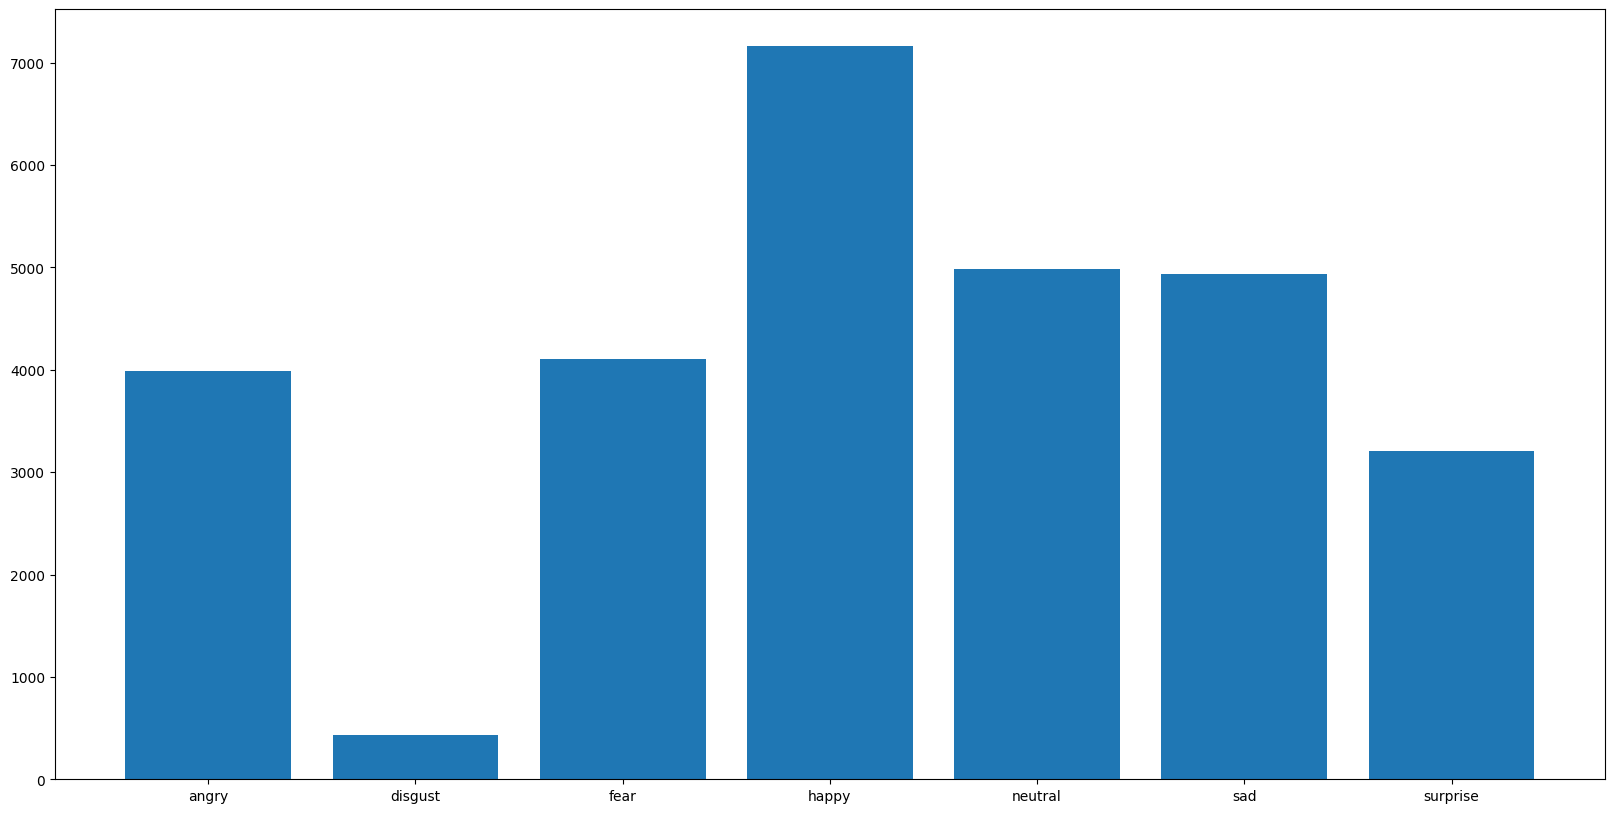

In [10]:
# Show class distribution
plt.figure(figsize=(20,10))
plt.bar(labels, [len(sets) for sets in label_ranges_train])

# Train Random Images per Label

In [11]:
# display 4 random images for each label
def displayRandomImages(train_images):
    global labels, per_label_range_train
    # plt.style.use('dark_background')
    fig, ax = plt.subplots(len(labels), 4, figsize=(10,10))
    fig.tight_layout()
    for i in range(7):
        l = random.sample(range(per_label_range_train[i][0],per_label_range_train[i][1]),4)
        for j in range(4):
            ax[i][j].imshow(train_images[l[j]])
            ax[i][j].set_title(train_labels[l[j]])
            ax[i][j].axis('off')
    plt.show()

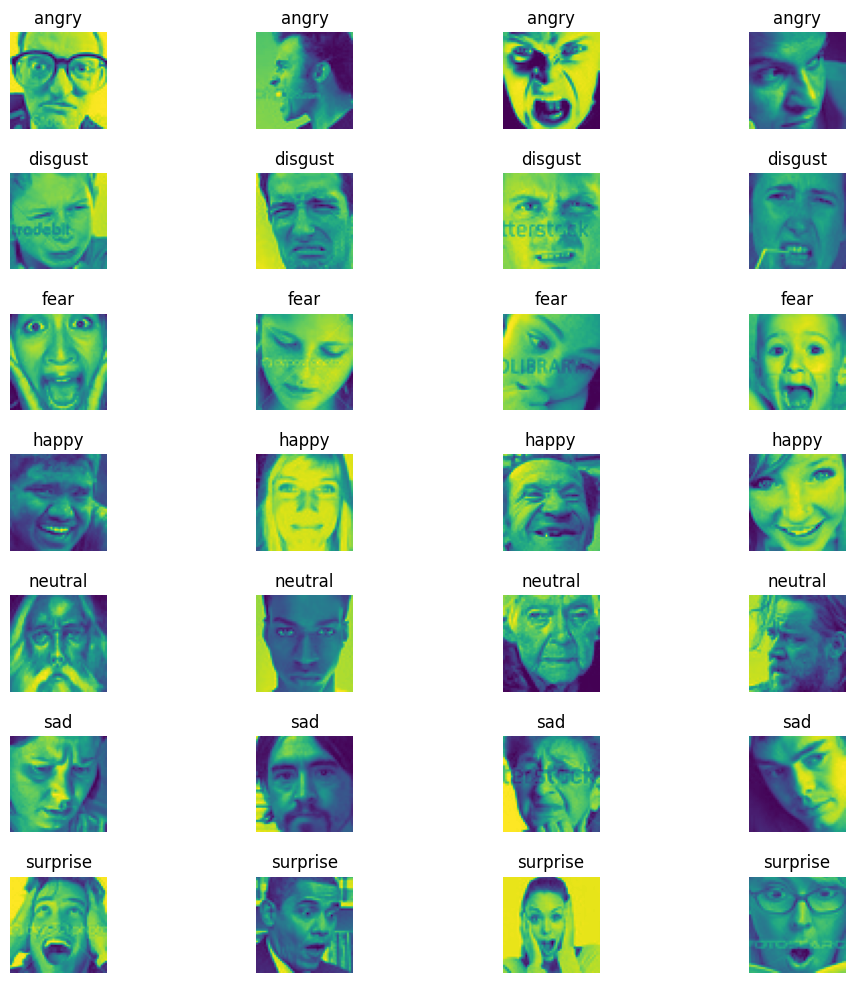

In [12]:
displayRandomImages(train_images)

In [13]:
# sleep 
import time
time.sleep(1)

In [14]:
from sklearn.utils import resample
from keras.preprocessing.image import ImageDataGenerator

for curLabel in labels:
    if curLabel == "happy":
        continue
    else:
        minority_class_images_start = 0
        minority_class_images_end = 0
        majority_class_images_start = 0
        majority_class_images_end = 0
        for i,rangeSet in enumerate(per_label_range_train):
            min,max,label,count = rangeSet
            if label == curLabel:
                print(rangeSet)
                minority_class_images_start = min
                minority_class_images_end = max
            elif label == "happy":
                majority_class_images_start = min
                majority_class_images_end = max

        minority_class_images = train_images[minority_class_images_start:minority_class_images_end+1]
        majority_class_images = train_images[majority_class_images_start:majority_class_images_end+1]

        print("Number of majority class images: ",len(majority_class_images))
        print("Number of minority class images: ",len(minority_class_images))

        oversampled_minority_class_images = resample(minority_class_images,
                                                    replace=True,
                                                    n_samples=len(majority_class_images),
                                                    random_state=42)
        
        # Define an ImageDataGenerator for augmentation
        datagen = ImageDataGenerator(
            rotation_range=10,      
            width_shift_range=0.1,  
            height_shift_range=0.1, 
            zoom_range=0.1,         
            horizontal_flip=True,   
            fill_mode='nearest'     
        )

        augmented_minority_images = []

        for images in oversampled_minority_class_images:
            
            for batch in datagen.flow(np.reshape(images, (1, images.shape[0], images.shape[1], 1)), batch_size=1):
                augmented_minority_images.extend(batch)
                break
            
        # reshape the augmented images
        shuffled_indexes = np.arange(len(augmented_minority_images))
        np.random.shuffle(shuffled_indexes)
        augmented_minority_images = np.array(augmented_minority_images)[shuffled_indexes]
        augmented_minority_images = [np.reshape(image, (image.shape[0], image.shape[1])) for image in augmented_minority_images]
            
        for i in range(minority_class_images_start,minority_class_images_end+1):
            del train_images[i]
            del train_labels[i]
            
        train_images = train_images + augmented_minority_images
        train_labels = train_labels + [curLabel]*len(oversampled_minority_class_images)


(20289, 24281, 'angry', 3993)
Number of majority class images:  7164
Number of minority class images:  3993
(24282, 24717, 'disgust', 436)
Number of majority class images:  7164
Number of minority class images:  436
(24718, 28820, 'fear', 4103)
Number of majority class images:  7164
Number of minority class images:  4103
(12102, 17083, 'neutral', 4982)
Number of majority class images:  7164
Number of minority class images:  4982
(0, 4937, 'sad', 4938)
Number of majority class images:  7164
Number of minority class images:  4938
(17084, 20288, 'surprise', 3205)
Number of majority class images:  7164
Number of minority class images:  3205


In [15]:
print("Number of train images",len(train_images))
print("Number of train labels",len(train_labels))

Number of train images 50148
Number of train labels 50148


# Perform Label Encoding

In [16]:
# label encode
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)
print(len(train_labels_encoded))
print(len(train_labels))

test_labels_encoded = le.transform(test_labels)
print(len(test_labels_encoded))
print(len(test_labels_encoded))


50148
50148
7066
7066


# Constructing CNN

In [17]:
train_images = np.array(train_images)
train_labels_encoded = np.array(train_labels_encoded)

train_images = train_images.reshape(-1,48,48,1)

print(train_images.shape)
print(train_labels_encoded.shape)

(50148, 48, 48, 1)
(50148,)


In [18]:
# # define model
import sklearn
import gc
# def defineModel():
#     model = None
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
#     model.add(tf.keras.layers.MaxPool2D((2, 2)))
#     model.add(tf.keras.layers.Dropout(0.2))
#     model.add(tf.keras.layers.BatchNormalization())

#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(units=64,activation='relu'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dense(units=len(labels),activation='softmax'))
    
#     model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#     model.compile(optimizer=model.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#     print(model.summary())
#     return model
    
# define model
# def defineModel(layer1_units, dense_units, dropout_rate, learning_rate):
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Conv2D(layer1_units, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
#     model.add(tf.keras.layers.MaxPool2D((2, 2)))
#     model.add(tf.keras.layers.Dropout(dropout_rate))
#     model.add(tf.keras.layers.BatchNormalization())

#     model.add(tf.keras.layers.Flatten())
#     model.add(tf.keras.layers.Dense(units=dense_units,activation='relu'))
#     model.add(tf.keras.layers.BatchNormalization())
#     model.add(tf.keras.layers.Dense(units=len(labels),activation='softmax'))
    
#     model.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#     model.compile(optimizer=model.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#     print(model.summary())
#     return model

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_accuracy',patience=5,verbose=1,restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,verbose=1,min_delta=0.0001)

callbacks_list=[early_stopping,reduce_learning_rate]

def defineModel(dropout_rate, learning_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), input_shape=(48,48,1)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Conv2D(64, kernel_size=(5, 5)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPool2D((2, 2)))
    model.add(tf.keras.layers.Dropout(dropout_rate))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=32))
    model.add(tf.keras.layers.BatchNormalization())
    # model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.Dense(units=len(labels),activation='softmax'))
    
    model.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=model.optimizer,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model


param_grid = {
    'dropout_rate': [0.2,0.3],
    'learning_rate': [0.001],
    'batch_size': [256,512],
    'epochs': [30]
}


def hyperParameterTuning(train_images,train_labels_encoded,validation_images,validation_labels,test_images,test_labels_encoded,param_grid):
    bestModel = None
    bestParams = None
    bestHistory = None
    bestAccuracy = float('-inf')

    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    print("Dropout_rate: ",dropout_rate," learning_rate: ",learning_rate," batch_size: ",batch_size, "Epochs: ",epochs)
                    model = defineModel(dropout_rate,learning_rate)
                    with tf.device('/GPU:0'):
                        history = model.fit(train_images,train_labels_encoded,epochs=epochs,batch_size=batch_size,validation_data=(validation_images,validation_labels),verbose=1,callbacks=callbacks_list)
                        _,accuracy = model.evaluate(test_images,test_labels_encoded,verbose=0)
                    if accuracy > bestAccuracy:
                        bestAccuracy = accuracy
                        bestModel = model
                        bestParams = {'dropout_rate': dropout_rate, 'learning_rate': learning_rate, 'batch_size': batch_size, 'epochs': epochs}
                        bestHistory = history
                    gc.collect()
    return bestModel,bestParams,bestHistory    
    


# Shuffle Training Data

In [19]:
# shuffle data
from sklearn.utils import shuffle
train_images, train_labels_encoded = shuffle(train_images, train_labels_encoded, random_state=42)

In [20]:
test_images = np.array(test_images).reshape(-1,48,48,1)

# Train Test Split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_encoded, test_size=0.2, random_state=42)

In [22]:
bestModel,bestParams,bestHistory = hyperParameterTuning(X_train,y_train,test_images,test_labels_encoded,X_test,y_test,param_grid)

Dropout_rate:  0.2  learning_rate:  0.001  batch_size:  256 Epochs:  30
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                  

2023-10-22 02:53:02.501013: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 02:53:02.693213: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 02:53:03.444067: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-22 02:53:04.597935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-22 02:53:07.130264: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558fbdc580c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-22 02:53:07.130314: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GP

157/157 [==============================] - 16s 60ms/step - loss: 1.7319 - accuracy: 0.3268 - val_loss: 1.6523 - val_accuracy: 0.3794 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 8s 51ms/step - loss: 1.5043 - accuracy: 0.4157 - val_loss: 1.6956 - val_accuracy: 0.4005 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 8s 50ms/step - loss: 1.4204 - accuracy: 0.4449 - val_loss: 1.6800 - val_accuracy: 0.3830 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 8s 51ms/step - loss: 1.3688 - accuracy: 0.4659 - val_loss: 1.5595 - val_accuracy: 0.4434 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 8s 51ms/step - loss: 1.3275 - accuracy: 0.4832 - val_loss: 1.9080 - val_accuracy: 0.3559 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 8s 51ms/step - loss: 1.2992 - accuracy: 0.4991 - val_loss: 1.7645 - val_accuracy: 0.4124 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 8s 51ms/step - loss:

2023-10-22 02:57:10.478891: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 02:57:10.708786: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 02:57:11.442292: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


79/79 [==============================] - 12s 102ms/step - loss: 1.8119 - accuracy: 0.2989 - val_loss: 2.0920 - val_accuracy: 0.2755 - lr: 0.0010
Epoch 2/30
79/79 [==============================] - 8s 95ms/step - loss: 1.5796 - accuracy: 0.3865 - val_loss: 2.3775 - val_accuracy: 0.2134 - lr: 0.0010
Epoch 3/30
79/79 [==============================] - 8s 95ms/step - loss: 1.4686 - accuracy: 0.4314 - val_loss: 1.6832 - val_accuracy: 0.3818 - lr: 0.0010
Epoch 4/30
79/79 [==============================] - 8s 95ms/step - loss: 1.4034 - accuracy: 0.4553 - val_loss: 1.8626 - val_accuracy: 0.3712 - lr: 0.0010
Epoch 5/30
79/79 [==============================] - 8s 96ms/step - loss: 1.3677 - accuracy: 0.4664 - val_loss: 1.7709 - val_accuracy: 0.3722 - lr: 0.0010
Epoch 6/30
79/79 [==============================] - 8s 95ms/step - loss: 1.3299 - accuracy: 0.4864 - val_loss: 1.6448 - val_accuracy: 0.4352 - lr: 0.0010
Epoch 7/30
79/79 [==============================] - 8s 95ms/step - loss: 1.3066 - acc

2023-10-22 03:01:02.625307: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 369727488 exceeds 10% of free system memory.
2023-10-22 03:01:03.612357: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


157/157 [==============================] - 9s 52ms/step - loss: 1.7941 - accuracy: 0.3053 - val_loss: 1.7021 - val_accuracy: 0.3643 - lr: 0.0010
Epoch 2/30
157/157 [==============================] - 8s 51ms/step - loss: 1.5735 - accuracy: 0.3865 - val_loss: 1.6220 - val_accuracy: 0.4053 - lr: 0.0010
Epoch 3/30
157/157 [==============================] - 8s 51ms/step - loss: 1.4866 - accuracy: 0.4185 - val_loss: 1.9508 - val_accuracy: 0.3534 - lr: 0.0010
Epoch 4/30
157/157 [==============================] - 8s 51ms/step - loss: 1.4236 - accuracy: 0.4462 - val_loss: 1.6006 - val_accuracy: 0.4188 - lr: 0.0010
Epoch 5/30
157/157 [==============================] - 8s 51ms/step - loss: 1.3854 - accuracy: 0.4595 - val_loss: 1.5902 - val_accuracy: 0.4363 - lr: 0.0010
Epoch 6/30
157/157 [==============================] - 8s 51ms/step - loss: 1.3531 - accuracy: 0.4758 - val_loss: 2.0193 - val_accuracy: 0.3020 - lr: 0.0010
Epoch 7/30
157/157 [==============================] - 8s 51ms/step - loss: 

2023-10-22 03:04:18.325575: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


79/79 [==============================] - 9s 97ms/step - loss: 1.8409 - accuracy: 0.2954 - val_loss: 2.2341 - val_accuracy: 0.2355 - lr: 0.0010
Epoch 2/30
79/79 [==============================] - 8s 95ms/step - loss: 1.6192 - accuracy: 0.3728 - val_loss: 3.1691 - val_accuracy: 0.1688 - lr: 0.0010
Epoch 3/30
79/79 [==============================] - 8s 96ms/step - loss: 1.5044 - accuracy: 0.4146 - val_loss: 2.6621 - val_accuracy: 0.2069 - lr: 0.0010
Epoch 4/30
78/79 [============================>.] - ETA: 0s - loss: 1.4442 - accuracy: 0.4399
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
79/79 [==============================] - 8s 95ms/step - loss: 1.4439 - accuracy: 0.4400 - val_loss: 2.3642 - val_accuracy: 0.2679 - lr: 0.0010
Epoch 5/30
79/79 [==============================] - 8s 95ms/step - loss: 1.3880 - accuracy: 0.4597 - val_loss: 1.7642 - val_accuracy: 0.3888 - lr: 5.0000e-04
Epoch 6/30
79/79 [==============================] - 8s 95ms/step - loss: 1.367

In [23]:
print("Best params: ",bestParams)
print("Best accuracy: ",bestHistory.history['val_accuracy'][-1])

Best params:  {'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 256, 'epochs': 30}
Best accuracy:  0.5084913969039917


In [24]:
# test_images = np.array(test_images).reshape(-1,48,48,1)
loss,accuracy = bestModel.evaluate(X_test,y_test)
print(f"Accuracy: {accuracy*100} Loss: {loss}")

314/314 [==============================] - 1s 4ms/step - loss: 1.2665 - accuracy: 0.5172
Accuracy: 51.7248272895813 Loss: 1.266469120979309


In [25]:
# print evaliation metrics such as f1 score, accracy, precision and recall
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

predictions = bestModel.predict(test_images)
predictions = np.argmax(predictions,axis=1)
print(classification_report(test_labels_encoded,predictions,labels=[0,1,2,3,4,5,6],target_names=labels))
print(confusion_matrix(test_labels_encoded,predictions))


221/221 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

       angry       0.46      0.30      0.37       960
     disgust       0.08      0.13      0.10       111
        fear       0.31      0.15      0.20      1018
       happy       0.72      0.76      0.74      1825
     neutral       0.44      0.60      0.51      1216
         sad       0.37      0.51      0.43      1139
    surprise       0.68      0.55      0.61       797

    accuracy                           0.51      7066
   macro avg       0.44      0.43      0.42      7066
weighted avg       0.51      0.51      0.50      7066

[[ 292   15   98  113  195  217   30]
 [  26   14   15   11   21   23    1]
 [ 125   43  153  100  183  302  112]
 [  45   22   35 1379  170  145   29]
 [  52    9   51  130  735  221   18]
 [  66   30   63   95  290  581   14]
 [  28   32   72   79   86   61  439]]


In [26]:
# !pip install numba